In [86]:
import numpy as np

In [87]:
import pandas as pd

In [88]:
from pathlib import Path

In [89]:
from skimage.io import imread

In [90]:
from time import time

In [91]:
import logging

In [92]:
import matplotlib.pyplot as plt

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
from sklearn.datasets import fetch_lfw_people

In [96]:
from sklearn.metrics import classification_report, confusion_matrix

In [97]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [98]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [99]:
print(lfw_people)

{'data': array([[254.      , 254.      , 251.66667 , ...,  87.333336,  88.666664,
         86.666664],
       [ 39.666668,  50.333332,  47.      , ..., 117.666664, 115.      ,
        133.66667 ],
       [ 89.333336, 104.      , 126.      , ..., 175.33333 , 183.33333 ,
        183.      ],
       ...,
       [ 86.      ,  80.333336,  74.666664, ...,  44.      ,  49.666668,
         44.666668],
       [ 50.333332,  65.666664,  88.      , ..., 197.      , 179.33333 ,
        166.33333 ],
       [ 30.      ,  27.      ,  32.666668, ...,  35.      ,  35.333332,
         61.      ]], dtype=float32), 'images': array([[[254.      , 254.      , 251.66667 , ...,  65.333336,
          50.666668,  40.333332],
        [253.33333 , 251.33333 , 247.33333 , ...,  66.666664,
          52.      ,  42.666668],
        [240.66667 , 231.66667 , 211.66667 , ...,  62.      ,
          49.      ,  42.      ],
        ...,
        [ 74.333336,  54.      ,  31.666666, ...,  97.666664,
          93.      ,  90.

In [100]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [101]:
n_samples, h, w = lfw_people.images.shape

In [102]:
n_samples

1288

In [103]:
h, w

(50, 37)

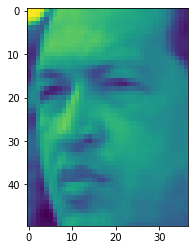

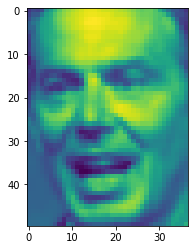

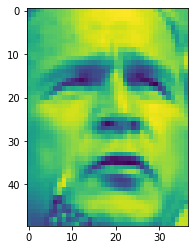

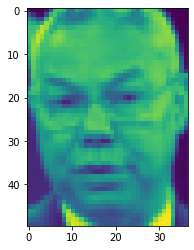

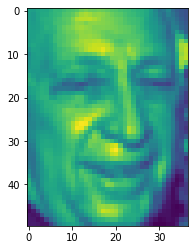

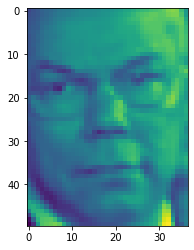

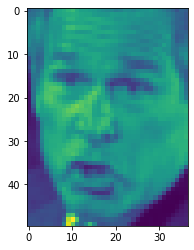

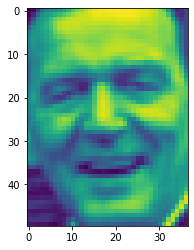

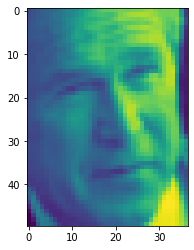

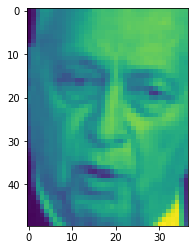

In [104]:
for i in range(10):
  plt.imshow(lfw_people.images[i])
  plt.show()


In [105]:
X = lfw_people.data
n_features = X.shape[1]

In [106]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names

In [107]:
n_classes = target_names.shape[0]

In [108]:
print("Total dataset size: %d")
print("n_sample: %d" %n_samples )
print("n_features: %d" %n_features)
print("n_classes: %d" % n_classes)

Total dataset size: %d
n_sample: 1288
n_features: 1850
n_classes: 7


In [132]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.25)

In [133]:
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
  % (n_components, x_train.shape[0]))
t0 = time() 
pca = PCA(n_components=n_components , svd_solver='randomized',
          whiten=True).fit(x_train)
print("done in %0.3fs" %(time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.192s


In [134]:
eigenfaces = pca.components_.reshape((n_components,h,w))

In [135]:
print("Projecting the input data on the eigen faces orthonormal basis")
t0 = time() 
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print("done in %0.3fs" %(time() - t0))

Projecting the input data on the eigen faces orthonormal basis
done in 0.030s


In [113]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001,0.0005,0.001,0.005,0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(x_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid_search")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 45.239s
Best estimator found by grid_search
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [136]:
print("predicting people names in the test set")
t0 =time()
y_pred = clf.predict(x_test_pca)

print("done in %0.3fs " % (time() - t0))

print(classification_report(y_test,y_pred,target_names=target_names))
print(confusion_matrix(y_test,y_pred, labels = range(n_classes)))

predicting people names in the test set
done in 0.079s 
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.04      0.07        25
     Colin Powell       0.53      0.57      0.55        54
  Donald Rumsfeld       0.17      0.10      0.12        20
    George W Bush       0.52      0.71      0.60       150
Gerhard Schroeder       0.27      0.11      0.16        27
      Hugo Chavez       0.00      0.00      0.00        17
       Tony Blair       0.23      0.24      0.24        29

         accuracy                           0.47       322
        macro avg       0.32      0.25      0.25       322
     weighted avg       0.42      0.47      0.42       322

[[  1   1   0  20   0   0   3]
 [  0  31   0  21   0   1   1]
 [  0   1   2  17   0   0   0]
 [  0  17   8 106   5   0  14]
 [  0   0   0  18   3   2   4]
 [  1   2   1  10   2   0   1]
 [  0   7   1  12   1   1   7]]


In [137]:
def plot_gallery(images,titles,h,w,n_row=3, n_col=4):
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom = 0, left= .01, right = .99, top= .90, hspace=.35)
  for i in range(n_row*n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

In [138]:
def title(y_pred, y_test, target_names, i):
  pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
  true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
  return 'predicted: %s\ntrue:    %s' % (pred_name,true_name)

In [139]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                    for i in range(y_pred.shape[0])]

In [140]:
prediction_titles

['predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Powell\ntrue:    Powell',
 'predicted: Bush\ntrue:    Chavez',
 'predicted: Bush\ntrue:    Chavez',
 'predicted: Blair\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Schroeder',
 'predicted: Bush\ntrue:    Powell',
 'predicted: Rumsfeld\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Schroeder\ntrue:    Chavez',
 'predicted: Bush\ntrue:    Chavez',
 'predicted: Bush\ntrue:    Rumsfeld',
 'predicted: Bush\ntrue:    Powell',
 'predicted: Powell\ntrue:    Sharon',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Powell',
 'predicted: Powell\ntrue:    Powell',
 'predicted: Bush\ntrue:    Sharon',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Bush',
 'predicted: Bush\ntrue:    Blair',
 'predi

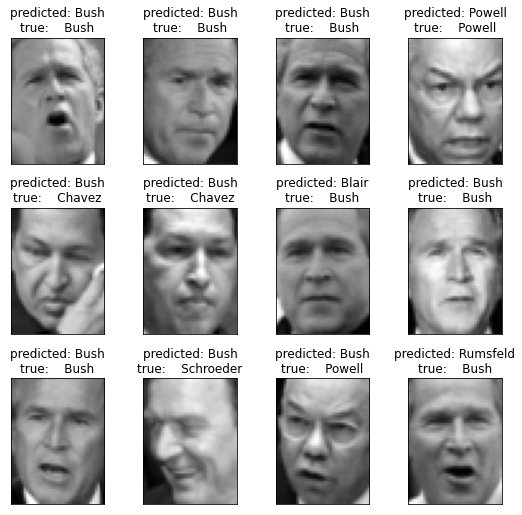

In [141]:
plot_gallery(x_test, prediction_titles,h,w)

In [120]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

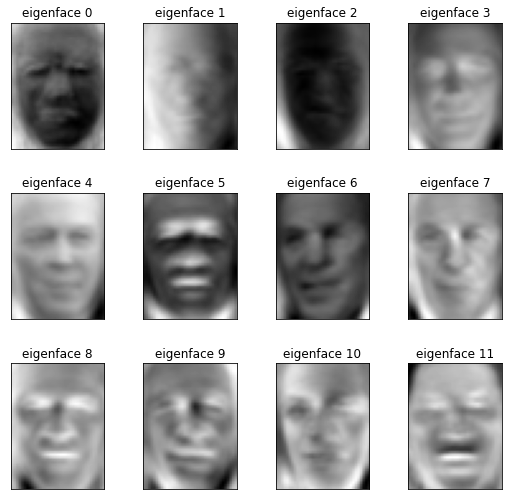

In [121]:
plot_gallery(eigenfaces,eigenface_titles,h,w)